# Predicting if it's going to rain using Decision Tree, Random Forest, XGBoost and CatBoost classifiers

Importing libraries

In [62]:
import numpy as np
import pandas as pd
import requests
from io import BytesIO
from io import StringIO
from zipfile import ZipFile
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report

URL to data sources: Brazil's National Institute of Meteorology

https://portal.inmet.gov.br/dadoshistoricos

Extracting and importing first sample of data (2022):

In [37]:
url = 'https://portal.inmet.gov.br/uploads/dadoshistoricos/2022.zip'

In [38]:
response = requests.get(url, stream=True)

z = ZipFile(BytesIO(response.content))

file_list = z.namelist()

for file in file_list[:10]:
  print(file)

INMET_CO_DF_A001_BRASILIA_01-01-2022_A_31-12-2022.CSV
INMET_CO_DF_A042_BRAZLANDIA_01-01-2022_A_31-12-2022.CSV
INMET_CO_DF_A045_AGUAS EMENDADAS_01-01-2022_A_31-12-2022.CSV
INMET_CO_DF_A046_GAMA (PONTE ALTA)_01-01-2022_A_31-12-2022.CSV
INMET_CO_DF_A047_PARANOA (COOPA-DF)_01-01-2022_A_31-12-2022.CSV
INMET_CO_GO_A002_GOIANIA_01-01-2022_A_31-12-2022.CSV
INMET_CO_GO_A003_MORRINHOS_01-01-2022_A_31-12-2022.CSV
INMET_CO_GO_A005_PORANGATU_01-01-2022_A_31-12-2022.CSV
INMET_CO_GO_A011_SAO SIMAO_01-01-2022_A_31-12-2022.CSV
INMET_CO_GO_A012_LUZIANIA_01-01-2022_A_31-12-2022.CSV


#### There are two sensors measuring weather conditions in the city of Sao Paulo. We'll only keep the first one's data. Let's have a look at how the raw data looks like.

In [39]:
sp_files = [sp_file for sp_file in file_list if 'SAO PAULO' in sp_file]

print(sp_files)

['INMET_SE_SP_A701_SAO PAULO - MIRANTE_01-01-2022_A_31-12-2022.CSV', 'INMET_SE_SP_A771_SAO PAULO - INTERLAGOS_01-01-2022_A_31-12-2022.CSV']


In [40]:
file_to_extract = sp_files[0]
extracted_file = z.open(file_to_extract)
content = extracted_file.read()

decoded_content = content.decode('ISO-8859-1')

print(decoded_content[:1000])

REGIAO:;SE
UF:;SP
ESTACAO:;SAO PAULO - MIRANTE
CODIGO (WMO):;A701
LATITUDE:;-23,49638888
LONGITUDE:;-46,61999999
ALTITUDE:;785,64
DATA DE FUNDACAO:;25/07/06
Data;Hora UTC;PRECIPITAÇÃO TOTAL, HORÁRIO (mm);PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB);PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB);PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB);RADIACAO GLOBAL (Kj/m²);TEMPERATURA DO AR - BULBO SECO, HORARIA (°C);TEMPERATURA DO PONTO DE ORVALHO (°C);TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C);TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C);TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C);TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C);UMIDADE REL. MAX. NA HORA ANT. (AUT) (%);UMIDADE REL. MIN. NA HORA ANT. (AUT) (%);UMIDADE RELATIVA DO AR, HORARIA (%);VENTO, DIREÇÃO HORARIA (gr) (° (gr));VENTO, RAJADA MAXIMA (m/s);VENTO, VELOCIDADE HORARIA (m/s);
2022/01/01;0000 UTC;0;920,5;920,5;920,1;;19,3;18;19,4;19,2;18,2;17,8;92;92;92;35;2,1;,7;
2022/01/01;0100 UTC;0;920,8;920,9;920,5;;19,1;17,9;

Let's decode the data and treat this data so we can convert it to a Pandas DataFrame.

In [41]:
start_index = decoded_content.find("Data")

result_string = decoded_content[start_index:]

print(result_string[:1000])

Data;Hora UTC;PRECIPITAÇÃO TOTAL, HORÁRIO (mm);PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB);PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB);PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB);RADIACAO GLOBAL (Kj/m²);TEMPERATURA DO AR - BULBO SECO, HORARIA (°C);TEMPERATURA DO PONTO DE ORVALHO (°C);TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C);TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C);TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C);TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C);UMIDADE REL. MAX. NA HORA ANT. (AUT) (%);UMIDADE REL. MIN. NA HORA ANT. (AUT) (%);UMIDADE RELATIVA DO AR, HORARIA (%);VENTO, DIREÇÃO HORARIA (gr) (° (gr));VENTO, RAJADA MAXIMA (m/s);VENTO, VELOCIDADE HORARIA (m/s);
2022/01/01;0000 UTC;0;920,5;920,5;920,1;;19,3;18;19,4;19,2;18,2;17,8;92;92;92;35;2,1;,7;
2022/01/01;0100 UTC;0;920,8;920,9;920,5;;19,1;17,9;19,4;19,1;18,1;17,8;93;92;93;122;1,8;,1;
2022/01/01;0200 UTC;0;920,8;921;920,7;;19;17,9;19,1;18,8;18;17,6;93;93;93;19;1,8;0;
2022/01/01;0300 UTC;0;920,4;920,

In [42]:
stringio = StringIO(result_string)
df = pd.read_csv(stringio, encoding='ISO-8859-1', sep=";")

df.head()

,Data,Hora UTC,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (Kj/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)",Unnamed: 19
0,2022/01/01,0000 UTC,0,"920,5","920,5","920,1",NaN,"19,3",18,"19,4","19,2","18,2","17,8",92,92,92,35,"2,1",",7",NaN
1,2022/01/01,0100 UTC,0,"920,8","920,9","920,5",NaN,"19,1","17,9","19,4","19,1","18,1","17,8",93,92,93,122,"1,8",",1",NaN
2,2022/01/01,0200 UTC,0,"920,8",921,"920,7",NaN,19,"17,9","19,1","18,8",18,"17,6",93,93,93,19,"1,8",0,NaN
3,2022/01/01,0300 UTC,0,"920,4","920,8","920,4",NaN,"18,7","17,5",19,"18,7","17,9","17,5",93,93,93,39,"1,7",0,NaN
4,2022/01/01,0400 UTC,0,"919,7","920,4","919,7",NaN,"18,5","17,3","18,7","18,5","17,5","17,3",93,93,93,63,",9",0,NaN


After some data treatment...


In [43]:
numeric_columns = df.select_dtypes(include='object').columns[2:]

df[numeric_columns] = df[numeric_columns].replace(',',
                                                  '.', regex=True).astype(float)

df['Data'] = pd.to_datetime(df['Data'])

df = df.drop(columns='Unnamed: 19')

df = df.drop(columns='Hora UTC')

df.head()

,Data,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (Kj/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)"
0,2022-01-01,0.0,920.5,920.5,920.1,NaN,19.3,18.0,19.4,19.2,18.2,17.8,92,92,92,35,2.1,0.7
1,2022-01-01,0.0,920.8,920.9,920.5,NaN,19.1,17.9,19.4,19.1,18.1,17.8,93,92,93,122,1.8,0.1
2,2022-01-01,0.0,920.8,921.0,920.7,NaN,19.0,17.9,19.1,18.8,18.0,17.6,93,93,93,19,1.8,0.0
3,2022-01-01,0.0,920.4,920.8,920.4,NaN,18.7,17.5,19.0,18.7,17.9,17.5,93,93,93,39,1.7,0.0
4,2022-01-01,0.0,919.7,920.4,919.7,NaN,18.5,17.3,18.7,18.5,17.5,17.3,93,93,93,63,0.9,0.0


We can aggregate the data by date ("Data" column). "PRECIPITAÇÃO TOTAL, HORÁRIO (mm)" and "RADIACAO GLOBAL (Kj/m²)" correspond to total rainfall and total capture solar radiation, so we can aggregate them by sum. The rest is aggregated by the mean.

In [44]:
columns_to_aggregate = df.columns.difference(['Data',
                                              'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)',
                                              'RADIACAO GLOBAL (Kj/m²)'])

df_final = df.groupby('Data').agg({'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)': 'sum',
                                   'RADIACAO GLOBAL (Kj/m²)': 'sum',
                                   **{col: 'mean' for col in columns_to_aggregate}}).reset_index()

df_final.head()

,Data,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)",RADIACAO GLOBAL (Kj/m²),"PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)"
0,2022-01-01,3.6,18744.4,920.750000,920.958333,920.475000,20.883333,17.800000,21.550000,20.325000,18.258333,17.341667,86.000000,80.208333,83.333333,123.541667,3.795833,0.958333
1,2022-01-02,2.8,15823.8,922.658333,922.887500,922.400000,22.695833,18.054167,23.354167,22.045833,18.666667,17.462500,79.500000,73.666667,76.708333,141.083333,3.933333,1.054167
2,2022-01-03,19.8,15269.8,922.404167,922.700000,922.175000,22.575000,18.866667,23.154167,22.012500,19.337500,18.470833,83.500000,78.041667,80.708333,147.083333,4.050000,1.145833
3,2022-01-04,15.0,13775.4,920.137500,920.450000,919.954167,22.550000,19.437500,23.100000,21.991667,19.779167,19.112500,86.000000,80.791667,83.208333,128.833333,4.741667,1.512500
4,2022-01-05,1.0,16000.8,918.700000,918.966667,918.479167,23.012500,18.591667,23.429167,22.737500,18.900000,18.366667,78.041667,74.500000,76.333333,109.541667,7.370833,2.654167


We want to predict whether there is or there is not going to be rain on a particular day, so our label must be related to 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)' (total rainfaill). We then check if we have a balanced dataset, considering rain or not rain. It appears to be quite balanced!

In [45]:
df_final['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'].value_counts(normalize=True)

0.0     0.512329
0.2     0.068493
0.4     0.024658
0.8     0.019178
0.6     0.019178
          ...   
0.6     0.002740
6.2     0.002740
2.6     0.002740
19.2    0.002740
9.2     0.002740
Name: PRECIPITAÇÃO TOTAL, HORÁRIO (mm), Length: 92, dtype: float64

Any day with rain will be labeled 1 and days without any rain will be labeled 0. Let's check our final dataset with some of its general information.

In [46]:
df_final['rain_label'] = np.where(df_final['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'] > 0.0, 1, 0)

df_final = df_final.drop(columns='PRECIPITAÇÃO TOTAL, HORÁRIO (mm)')

df_final = df_final.set_index('Data')

df_final.head()

,RADIACAO GLOBAL (Kj/m²),"PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)",rain_label
Data,,,,,,,,,,,,,,,,,
2022-01-01,18744.4,920.750000,920.958333,920.475000,20.883333,17.800000,21.550000,20.325000,18.258333,17.341667,86.000000,80.208333,83.333333,123.541667,3.795833,0.958333,1
2022-01-02,15823.8,922.658333,922.887500,922.400000,22.695833,18.054167,23.354167,22.045833,18.666667,17.462500,79.500000,73.666667,76.708333,141.083333,3.933333,1.054167,1
2022-01-03,15269.8,922.404167,922.700000,922.175000,22.575000,18.866667,23.154167,22.012500,19.337500,18.470833,83.500000,78.041667,80.708333,147.083333,4.050000,1.145833,1
2022-01-04,13775.4,920.137500,920.450000,919.954167,22.550000,19.437500,23.100000,21.991667,19.779167,19.112500,86.000000,80.791667,83.208333,128.833333,4.741667,1.512500,1
2022-01-05,16000.8,918.700000,918.966667,918.479167,23.012500,18.591667,23.429167,22.737500,18.900000,18.366667,78.041667,74.500000,76.333333,109.541667,7.370833,2.654167,1


In [47]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2022-01-01 to 2022-12-31
Data columns (total 17 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   RADIACAO GLOBAL (Kj/m²)                                365 non-null    float64
 1   PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)  365 non-null    float64
 2   PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)        365 non-null    float64
 3   PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)       365 non-null    float64
 4   TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)           365 non-null    float64
 5   TEMPERATURA DO PONTO DE ORVALHO (°C)                   365 non-null    float64
 6   TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)             365 non-null    float64
 7   TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)             365 non-null    float64
 8   TEMPERATURA ORVALHO MAX. NA HOR

Now it's time to expand the data. Let's get data from other years (2020 and 2021).

In [49]:
df_final_2022 = df_final.copy()

df_final_2022.head()

,RADIACAO GLOBAL (Kj/m²),"PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)",rain_label
Data,,,,,,,,,,,,,,,,,
2022-01-01,18744.4,920.750000,920.958333,920.475000,20.883333,17.800000,21.550000,20.325000,18.258333,17.341667,86.000000,80.208333,83.333333,123.541667,3.795833,0.958333,1
2022-01-02,15823.8,922.658333,922.887500,922.400000,22.695833,18.054167,23.354167,22.045833,18.666667,17.462500,79.500000,73.666667,76.708333,141.083333,3.933333,1.054167,1
2022-01-03,15269.8,922.404167,922.700000,922.175000,22.575000,18.866667,23.154167,22.012500,19.337500,18.470833,83.500000,78.041667,80.708333,147.083333,4.050000,1.145833,1
2022-01-04,13775.4,920.137500,920.450000,919.954167,22.550000,19.437500,23.100000,21.991667,19.779167,19.112500,86.000000,80.791667,83.208333,128.833333,4.741667,1.512500,1
2022-01-05,16000.8,918.700000,918.966667,918.479167,23.012500,18.591667,23.429167,22.737500,18.900000,18.366667,78.041667,74.500000,76.333333,109.541667,7.370833,2.654167,1


In [50]:
url_list = ['https://portal.inmet.gov.br/uploads/dadoshistoricos/2021.zip',
           'https://portal.inmet.gov.br/uploads/dadoshistoricos/2020.zip']

def ETL_data(url_year):

  print(url_year)

  response = requests.get(url_year, stream=True)

  z = ZipFile(BytesIO(response.content))

  file_list = z.namelist()

  sp_files = [sp_file for sp_file in file_list if 'SAO PAULO' in sp_file]

  file_to_extract = sp_files[0]
  extracted_file = z.open(file_to_extract)
  content = extracted_file.read()

  decoded_content = content.decode('ISO-8859-1')

  start_index = decoded_content.find("Data")

  result_string = decoded_content[start_index:]

  stringio = StringIO(result_string)
  df = pd.read_csv(stringio, encoding='ISO-8859-1', sep=";")

  numeric_columns = df.select_dtypes(include='object').columns[2:]

  df[numeric_columns] = df[numeric_columns].replace(',',
                                                    '.', regex=True).astype(float)

  df['Data'] = pd.to_datetime(df['Data'])

  df = df.drop(columns='Unnamed: 19')

  df = df.drop(columns='Hora UTC')

  columns_to_aggregate = df.columns.difference(['Data',
                                                'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)',
                                                'RADIACAO GLOBAL (Kj/m²)'])

  df_final = df.groupby('Data').agg({'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)': 'sum',
                                    'RADIACAO GLOBAL (Kj/m²)': 'sum',
                                    **{col: 'mean' for col in columns_to_aggregate}}).reset_index()

  df_final['rain_label'] = np.where(df_final['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'] > 0.0, 1, 0)

  df_final = df_final.drop(columns='PRECIPITAÇÃO TOTAL, HORÁRIO (mm)')

  df_final = df_final.set_index('Data')

  df_final = df_final.dropna()

  return df_final

df_list = [ETL_data(url) for url in url_list]

df_list.insert(0, df_final_2022)

https://portal.inmet.gov.br/uploads/dadoshistoricos/2021.zip
https://portal.inmet.gov.br/uploads/dadoshistoricos/2020.zip


Now we can build a unified dataset comprehending 3 years:

In [51]:
df_final = pd.concat(df_list)

print(df.info())

df_final.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 18 columns):
 #   Column                                                 Non-Null Count  Dtype         
---  ------                                                 --------------  -----         
 0   Data                                                   8760 non-null   datetime64[ns]
 1   PRECIPITAÇÃO TOTAL, HORÁRIO (mm)                       8759 non-null   float64       
 2   PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)  8760 non-null   float64       
 3   PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)        8760 non-null   float64       
 4   PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)       8760 non-null   float64       
 5   RADIACAO GLOBAL (Kj/m²)                                4563 non-null   float64       
 6   TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)           8760 non-null   float64       
 7   TEMPERATURA DO PONTO DE ORVALHO (°C)                   8760 non-null 

,RADIACAO GLOBAL (Kj/m²),"PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)",rain_label
Data,,,,,,,,,,,,,,,,,
2022-01-01,18744.4,920.750000,920.958333,920.475000,20.883333,17.800000,21.550000,20.325000,18.258333,17.341667,86.000000,80.208333,83.333333,123.541667,3.795833,0.958333,1
2022-01-02,15823.8,922.658333,922.887500,922.400000,22.695833,18.054167,23.354167,22.045833,18.666667,17.462500,79.500000,73.666667,76.708333,141.083333,3.933333,1.054167,1
2022-01-03,15269.8,922.404167,922.700000,922.175000,22.575000,18.866667,23.154167,22.012500,19.337500,18.470833,83.500000,78.041667,80.708333,147.083333,4.050000,1.145833,1
2022-01-04,13775.4,920.137500,920.450000,919.954167,22.550000,19.437500,23.100000,21.991667,19.779167,19.112500,86.000000,80.791667,83.208333,128.833333,4.741667,1.512500,1
2022-01-05,16000.8,918.700000,918.966667,918.479167,23.012500,18.591667,23.429167,22.737500,18.900000,18.366667,78.041667,74.500000,76.333333,109.541667,7.370833,2.654167,1


We can explore the correlation factors between columns to analyze if we can discard some of them. Seeing columns with very strong correlation factors can mean one of them could be redundant in the training process.

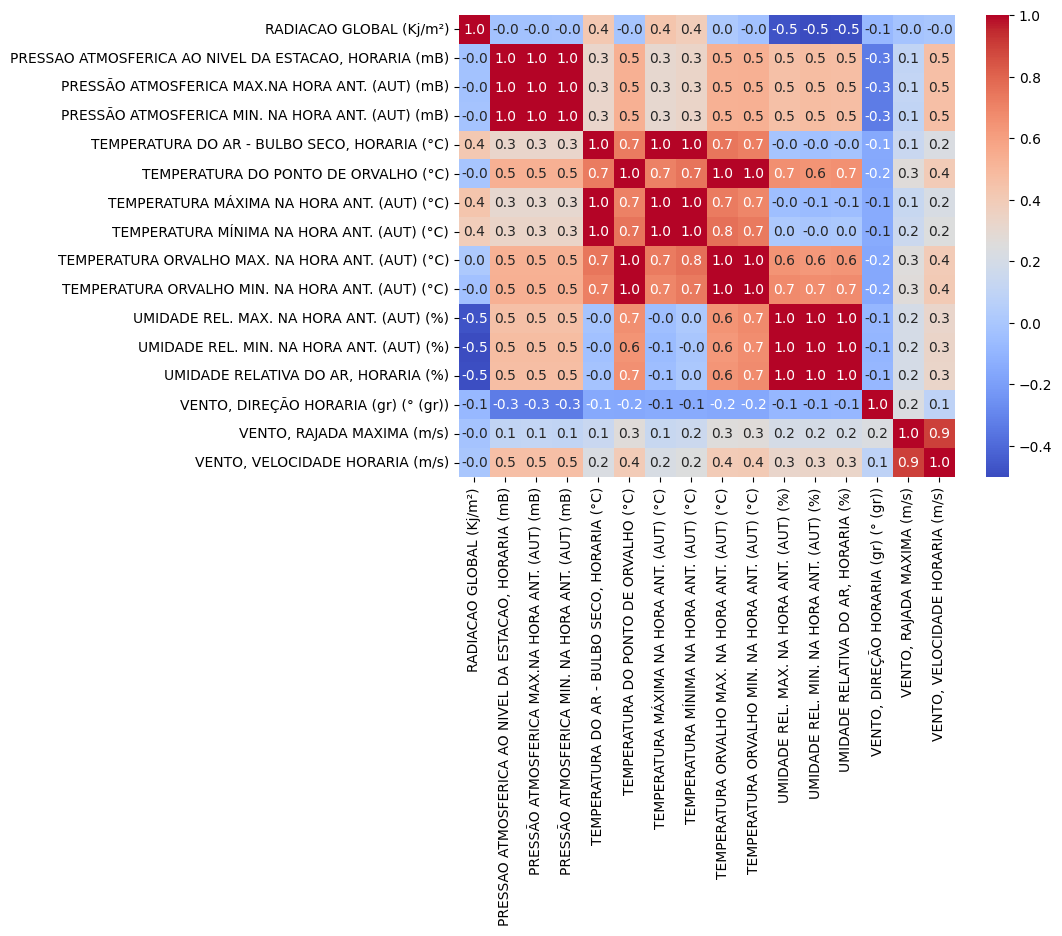

In [52]:
correlation_matrix = df_final.drop(columns='rain_label').corr()

plt.figure(figsize=(8, 6))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".1f")

plt.show()

As there are a lot of columns with correlation factor of 1.0 (the strongest positive correlation of them all), we are going to drop some columns:

In [53]:
df_final = df_final.drop(columns=['PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)',
'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)',
'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)',
'TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)',
'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)',
'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)',
'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)',
'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)',
'VENTO, VELOCIDADE HORARIA (m/s)',
'TEMPERATURA DO PONTO DE ORVALHO (°C)'])

And now we have features that behave more independently from each other.

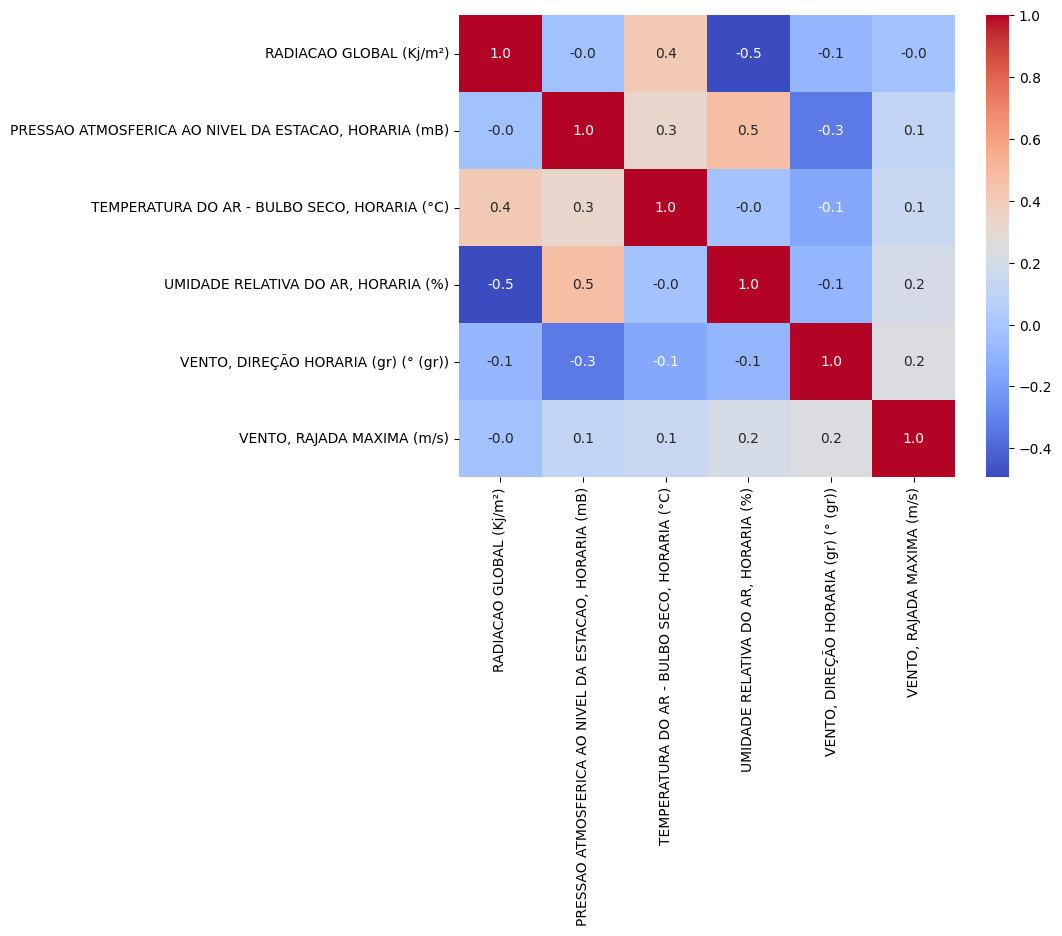

In [54]:
correlation_matrix = df_final.drop(columns='rain_label').corr()

plt.figure(figsize=(8, 6))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".1f")

plt.show()

Let's start training and testing models now. We will create a function to fit and test different models with the data.

In [55]:
y = df_final.rain_label

X = df_final.drop(columns='rain_label')

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

def fit_model(model_clf):

  clf = model_clf

  clf.fit(X_train, y_train)

  y_pred = clf.predict(X_test)

  accuracy = accuracy_score(y_test, y_pred)
  print(f"Accuracy: {accuracy:.2f}")

  print("Classification Report:")
  print(classification_report(y_test, y_pred))

  feature_importances = clf.feature_importances_

  for feature, importance in zip(X.columns, feature_importances):
      print(f"{feature}: {importance:.4f}")

  plt.bar(X.columns, feature_importances)
  plt.xticks(rotation=90, fontsize='small')
  plt.show()

  return clf

Decision Tree:

Accuracy: 0.71
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.80      0.76        87
           1       0.69      0.58      0.63        66

    accuracy                           0.71       153
   macro avg       0.70      0.69      0.69       153
weighted avg       0.70      0.71      0.70       153

RADIACAO GLOBAL (Kj/m²): 0.0909
PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB): 0.1274
TEMPERATURA DO AR - BULBO SECO, HORARIA (°C): 0.0652
UMIDADE RELATIVA DO AR, HORARIA (%): 0.4979
VENTO, DIREÇÃO HORARIA (gr) (° (gr)): 0.1324
VENTO, RAJADA MAXIMA (m/s): 0.0861


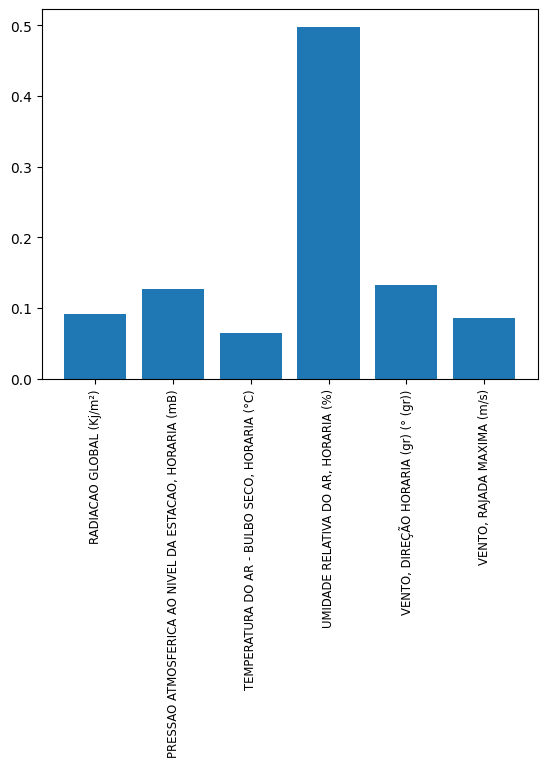

In [56]:
tree_clf = fit_model(DecisionTreeClassifier())

Random Forest Classifier:

Accuracy: 0.79
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.86      0.82        87
           1       0.79      0.70      0.74        66

    accuracy                           0.79       153
   macro avg       0.79      0.78      0.78       153
weighted avg       0.79      0.79      0.79       153

RADIACAO GLOBAL (Kj/m²): 0.1872
PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB): 0.1307
TEMPERATURA DO AR - BULBO SECO, HORARIA (°C): 0.1114
UMIDADE RELATIVA DO AR, HORARIA (%): 0.3588
VENTO, DIREÇÃO HORARIA (gr) (° (gr)): 0.1152
VENTO, RAJADA MAXIMA (m/s): 0.0967


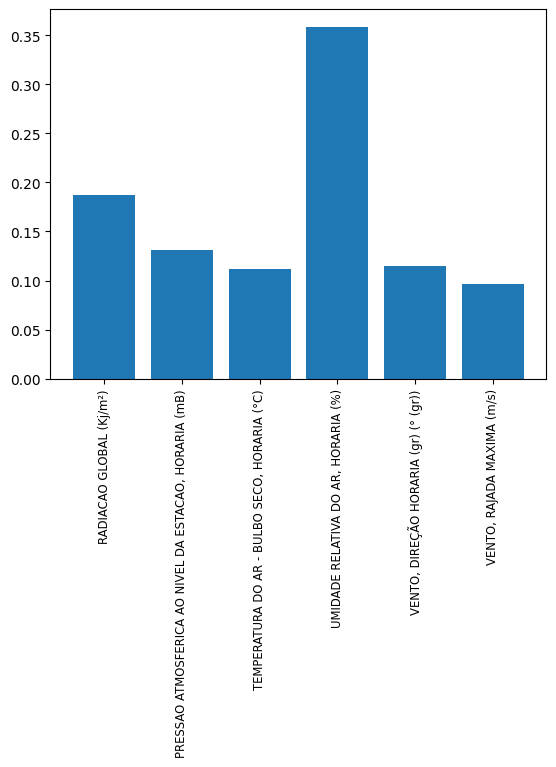

In [57]:
rf_clf = fit_model(RandomForestClassifier())

XGBoost Classifier:

Accuracy: 0.74
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.82      0.78        87
           1       0.72      0.64      0.68        66

    accuracy                           0.74       153
   macro avg       0.74      0.73      0.73       153
weighted avg       0.74      0.74      0.74       153

RADIACAO GLOBAL (Kj/m²): 0.0947
PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB): 0.1536
TEMPERATURA DO AR - BULBO SECO, HORARIA (°C): 0.0949
UMIDADE RELATIVA DO AR, HORARIA (%): 0.4482
VENTO, DIREÇÃO HORARIA (gr) (° (gr)): 0.1149
VENTO, RAJADA MAXIMA (m/s): 0.0938


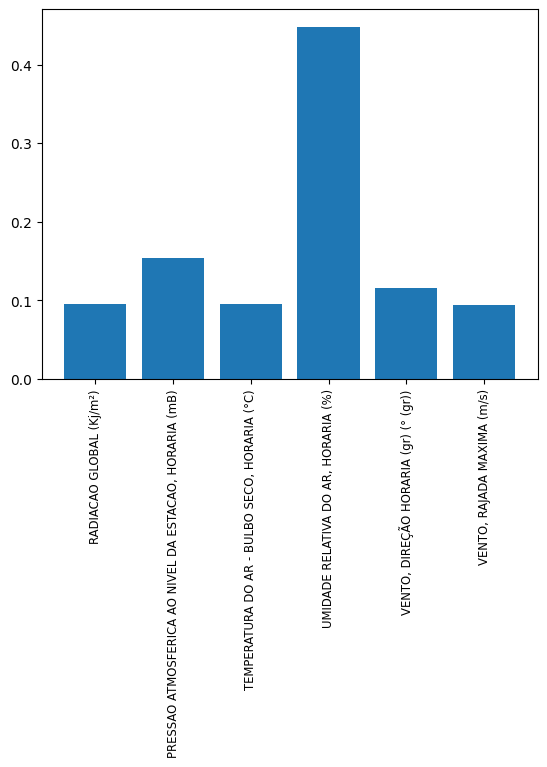

In [58]:
xgb_clf = fit_model(XGBClassifier())

CatBoost Classifier:

Accuracy: 0.81
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84        87
           1       0.80      0.74      0.77        66

    accuracy                           0.81       153
   macro avg       0.81      0.80      0.80       153
weighted avg       0.81      0.81      0.81       153

RADIACAO GLOBAL (Kj/m²): 12.4482
PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB): 16.4914
TEMPERATURA DO AR - BULBO SECO, HORARIA (°C): 11.3092
UMIDADE RELATIVA DO AR, HORARIA (%): 30.2349
VENTO, DIREÇÃO HORARIA (gr) (° (gr)): 16.3626
VENTO, RAJADA MAXIMA (m/s): 13.1538


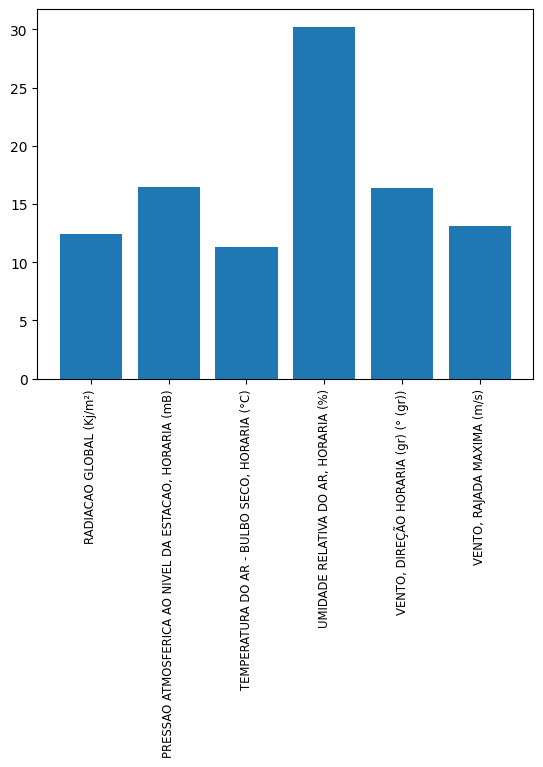

In [59]:
cat_clf = fit_model(CatBoostClassifier(verbose=False))

CatBoost gave us a very good result just using default parameters. We will use it to predict rainfall in 2023. Treating the data the same way we did before...

In [60]:
url = 'https://portal.inmet.gov.br/uploads/dadoshistoricos/2023.zip'

response = requests.get(url, stream=True)

z = ZipFile(BytesIO(response.content))

file_list = z.namelist()

sp_files = [sp_file for sp_file in file_list if 'SAO PAULO' in sp_file]

file_to_extract = sp_files[0]
extracted_file = z.open(file_to_extract)
content = extracted_file.read()

decoded_content = content.decode('ISO-8859-1')

start_index = decoded_content.find("Data")

result_string = decoded_content[start_index:]

stringio = StringIO(result_string)
df = pd.read_csv(stringio, encoding='ISO-8859-1', sep=";")

numeric_columns = df.select_dtypes(include='object').columns[2:]

df[numeric_columns] = df[numeric_columns].replace(',',
                                                  '.', regex=True).astype(float)

df['Data'] = pd.to_datetime(df['Data'])

df = df.drop(columns='Unnamed: 19')

df = df.drop(columns='Hora UTC')

columns_to_aggregate = df.columns.difference(['Data',
                                              'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)',
                                              'RADIACAO GLOBAL (Kj/m²)'])

df_final = df.groupby('Data').agg({'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)': 'sum',
                                   'RADIACAO GLOBAL (Kj/m²)': 'sum',
                                   **{col: 'mean' for col in columns_to_aggregate}}).reset_index()

df_final['rain_label'] = np.where(df_final['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'] > 0.0, 1, 0)

df_final = df_final.drop(columns='PRECIPITAÇÃO TOTAL, HORÁRIO (mm)')

df_final = df_final.set_index('Data')

df_final = df_final.dropna()

df_final = df_final.drop(columns=['PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)',
'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)',
'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)',
'TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)',
'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)',
'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)',
'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)',
'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)',
'VENTO, VELOCIDADE HORARIA (m/s)',
'TEMPERATURA DO PONTO DE ORVALHO (°C)'])

df_final.head()

,RADIACAO GLOBAL (Kj/m²),"PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)","TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)","UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)",rain_label
Data,,,,,,,
2023-01-01,23566.0,926.091667,22.600000,73.916667,162.916667,4.129167,1
2023-01-02,22467.2,923.708333,23.412500,67.666667,140.125000,5.687500,0
2023-01-03,19422.3,921.570833,23.191667,68.750000,78.291667,6.645833,1
2023-01-04,14611.3,921.220833,21.341667,79.375000,197.500000,7.316667,1
2023-01-05,6381.0,923.983333,17.262500,91.791667,204.333333,5.229167,1


We are able to find nice results for 2023 (unseen data so far)!

In [61]:
y = df_final.rain_label

X = df_final.drop(columns='rain_label')

y_pred = cat_clf.predict(X)

accuracy = accuracy_score(y, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("Classification Report:")
print(classification_report(y, y_pred))

Accuracy: 0.79
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.78      0.80       185
           1       0.74      0.80      0.77       148

    accuracy                           0.79       333
   macro avg       0.79      0.79      0.79       333
weighted avg       0.79      0.79      0.79       333

